In [25]:
import pandas as pd

df = pd.read_csv("./twitter_data/big_twitter_data.csv", header=None, encoding='latin1')
df.columns = ['user', 'tweet_id', 'date', 'device', 'username', 'tweet']
df

,user,tweet_id,date,device,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Serial Processing

In [34]:
from pprint import pprint
from collections import Counter
from util import clean_word, word_not_in_stopwords
import time

def word_counter(df):
    counter = Counter()
    for tweet in df['tweet']:
        words = list(map(lambda word: clean_word(word), tweet.split()))
        words = list(filter(word_not_in_stopwords, words))
        counter.update(words)
    return counter

start = time.time()
pprint(word_counter(df).most_common(10))
end = time.time()

print(f"Duration = {end-start}ms")

[('im', 177478),
 ('good', 89398),
 ('day', 82363),
 ('get', 81484),
 ('like', 77748),
 ('go', 72911),
 ('dont', 66923),
 ('today', 64601),
 ('going', 64087),
 ('love', 63463)]
Duration = 24.89664649963379ms


## Parallel Processing

In [ ]:
from functools import reduce

def mapper(tweet):
    words = list(map(lambda word: clean_word(word), tweet.split()))
    words = list(filter(word_not_in_stopwords, words))
    return Counter(words)
    
def reducer(counter1, counter2):
    counter1.update(counter2)
    return counter1

def chunk_mapper(chunk):
    counter = map(mapper, chunk)
    counter = reduce(reducer, counter)
    return counter

start = time.time()
pprint(chunk_mapper(df['tweet']).most_common(10))
end = time.time()

print(f"Duration = {end-start}ms")

[('im', 177478),
 ('good', 89398),
 ('day', 82363),
 ('get', 81484),
 ('like', 77748),
 ('go', 72911),
 ('dont', 66923),
 ('today', 64601),
 ('going', 64087),
 ('love', 63463)]
Duration = 29.7137131690979ms


In [36]:
from util import split_data_into_chunks
from multiprocessing import Pool
import time

pools = 9

chunks = split_data_into_chunks(df['tweet'], len(df['tweet'])//pools)

print(f"Number of Chunks {len(chunks)}")

start = time.time()

with Pool(pools) as p:
  mapped = p.map(chunk_mapper, chunks)

counter = Counter()
for idx in range(0, len(mapped)):
  counter = reducer(counter, mapped[idx])


end = time.time()
pprint(counter.most_common(10))

print(f"Duration = {end-start}ms")

Number of Chunks 10
[('im', 177478),
 ('good', 89398),
 ('day', 82363),
 ('get', 81484),
 ('like', 77748),
 ('go', 72911),
 ('dont', 66923),
 ('today', 64601),
 ('going', 64087),
 ('love', 63463)]
Duration = 6.511278867721558ms


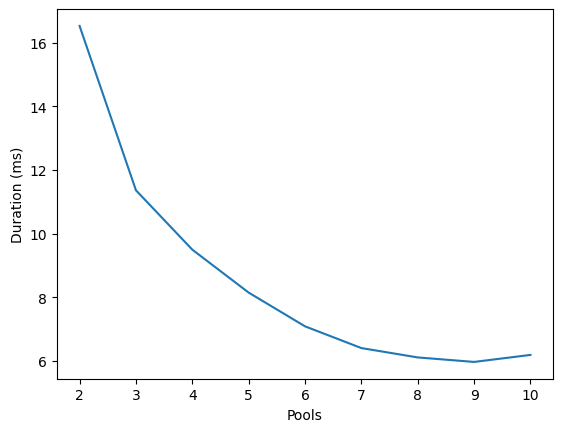

In [29]:
durs = []

def run(pools):
  chunks = split_data_into_chunks(df['tweet'], len(df['tweet'])//pools)
  start = time.time()
  with Pool(pools) as p:
    mapped = p.map(chunk_mapper, chunks)
  end = time.time()
  durs.append(end-start)

pools = list(range(2, 11))

for pool in pools:
  run(pool)

import matplotlib.pyplot as plt

plt.plot(pools, durs)
plt.xlabel("Pools")
plt.ylabel("Duration (ms)")
plt.show()